In [50]:
from pathlib import Path
import pandas as pd
import numpy as np
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager

DATA_PATH = Path('/home/engaclew/neurogen')
columns = ['recording_filename', '5s_CTC', 'voc_chi', 'voc_dur_chi']

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Read metadata
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'recording_filename']]
aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures['can_voc_dur_CHI'] = human_measures['can_voc_dur_CHI'] / 1000

def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)
# LENA already has CVC

def group_data(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    data = data.groupby('recording_filename').agg({
        '5s_CTC': np.sum,
        'voc_dur_chi': np.sum,
        'voc_chi': np.sum,
        'wc_adu': np.sum,
        'CVC': np.sum,
        'group_id': 'first',
        'child_id': 'first'
    }).reset_index()
    return data

aclew_measures = group_data(aclew_measures)
lena_measures = group_data(lena_measures)
human_measures = human_measures.groupby('recording_filename').agg({
    '5s_CTC': np.sum,
    'voc_dur_chi': np.sum,
    'voc_chi': np.sum,
    'wc_adu': np.sum,
    'CVC': np.sum,
    'can_voc_CHI': np.sum, # number of canonical voc. by CHI
    'cp_dur': np.mean, # canonical proportion on the duration of CHI voc
    'can_voc_dur_CHI': np.sum, # cum. dur. of canonical voc. by CHI
    'group_id': 'first',
    'child_id': 'first'
}).reset_index()

# Compute mean and mean percentage error
def compute_me(x, y):
    """ Compute mean error """
    me_list = (x-y).values
    return me_list

def compute_mpe(x, y):
    """ Compute mean error """
    errors = np.zeros_like(x, dtype=float)
    # Case 1: y != 0 - standard MPE calculation
    mask_nonzero = (y != 0)
    errors[mask_nonzero] = (x[mask_nonzero] - y[mask_nonzero]) / y[mask_nonzero]
    # Case 2: y = 0 and x != 0 -> error = 1
    mask_zero_error = (y == 0) & (x != 0)
    errors[mask_zero_error] = 1
    # Case 3: y = 0 and x = 0 -> error = 0 is already handled by initialization
    return 100*errors

cols = ['5s_CTC', 'wc_adu', 'CVC']
lena_scores, aclew_scores = pd.DataFrame(), pd.DataFrame()
for col in cols:
    lena_scores[f'{col}_me'] = compute_me(lena_measures[col], human_measures[col])
    lena_scores[f'{col}_mpe'] = compute_mpe(lena_measures[col], human_measures[col])
    aclew_scores[f'{col}_me'] = compute_me(aclew_measures[col], human_measures[col])
    aclew_scores[f'{col}_mpe'] = compute_mpe(aclew_measures[col], human_measures[col])
copy_cols = ['recording_filename', 'group_id', 'child_id', 'can_voc_CHI', 'cp_dur', 'can_voc_dur_CHI']
for col in copy_cols:
    lena_scores[col] = human_measures[col]
    aclew_scores[col] = human_measures[col]

/tmp/ipykernel_26148/3208291543.py:36: FutureWarning: The provided callable <function sum at 0x7ba6c03ceef0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykernel_26148/3208291543.py:36: FutureWarning: The provided callable <function sum at 0x7ba6c03ceef0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykernel_26148/3208291543.py:36: FutureWarning: The provided callable <function sum at 0x7ba6c03ceef0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.groupby('recording_filename').agg({
/tmp/ipykerne

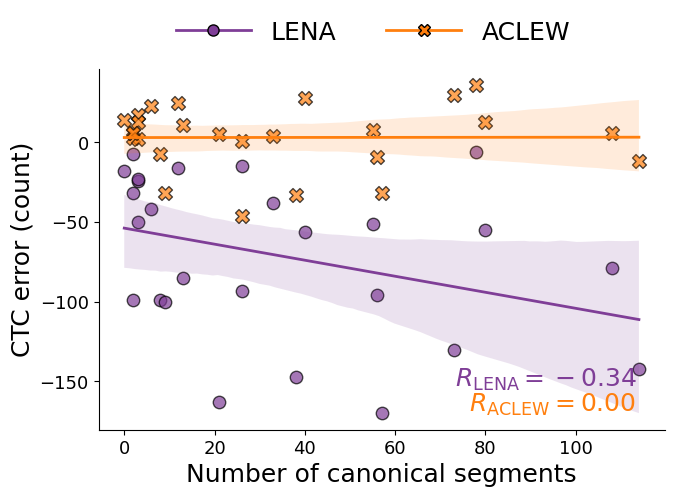

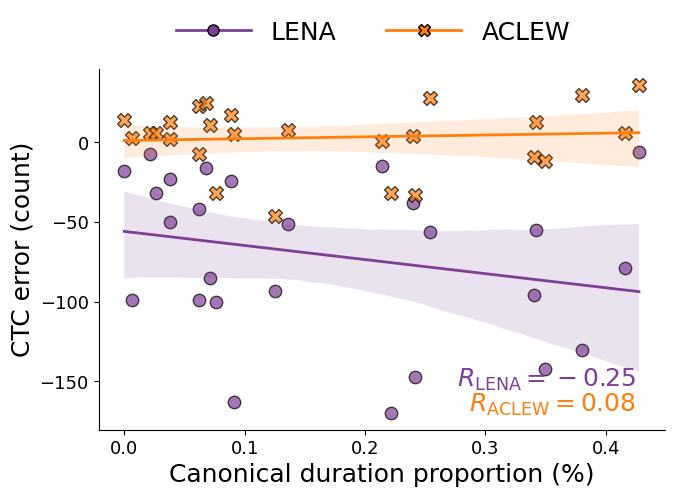

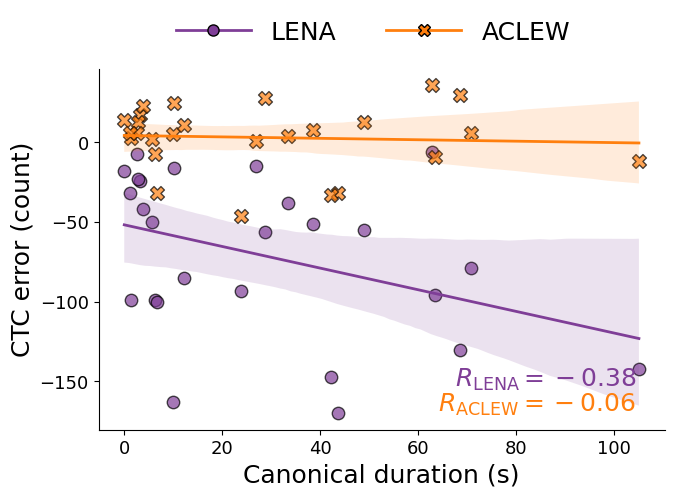

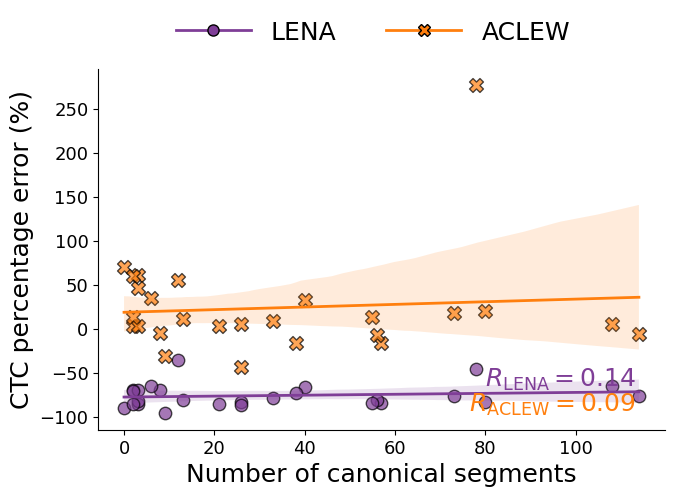

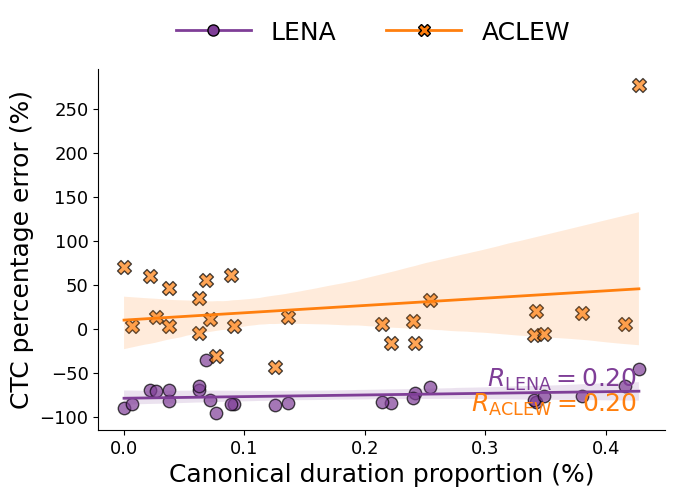

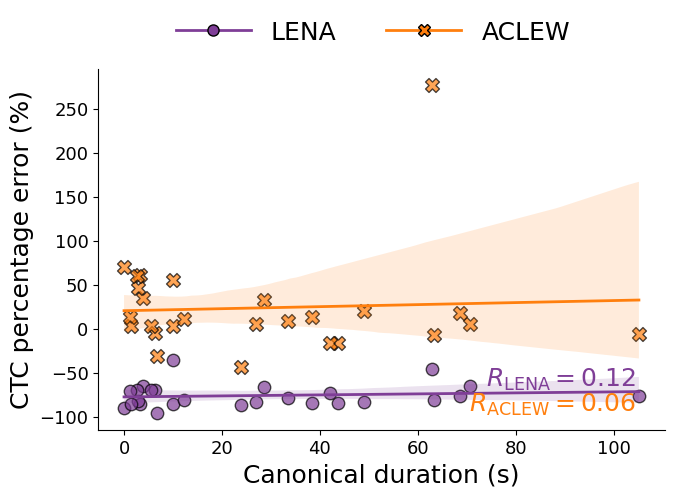

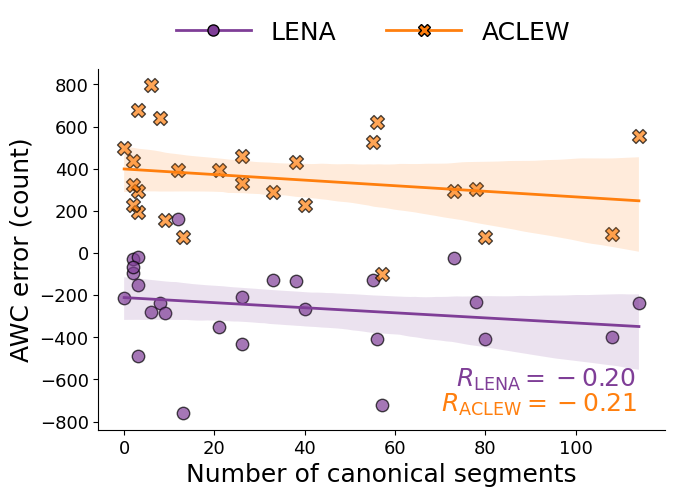

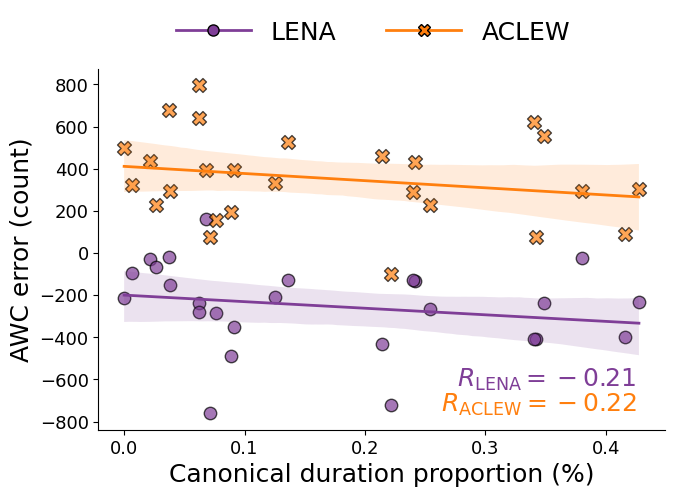

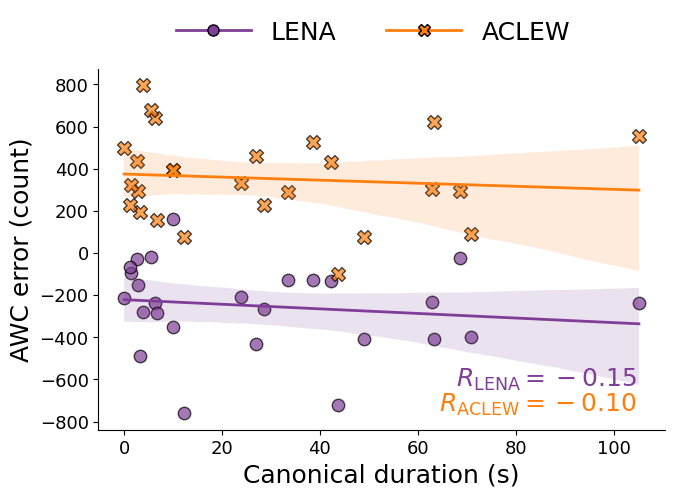

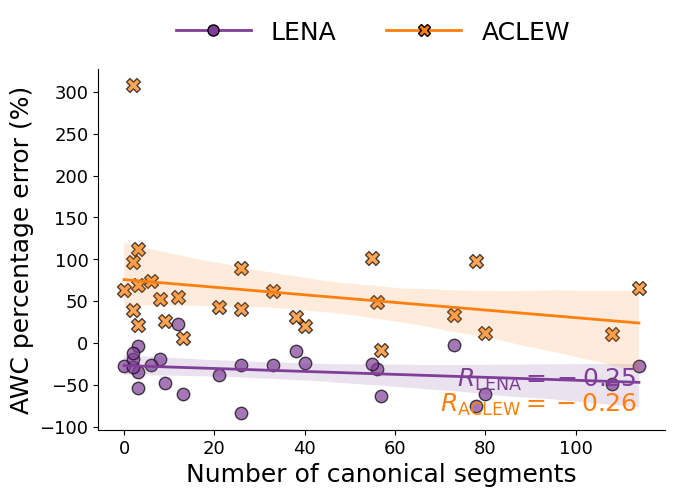

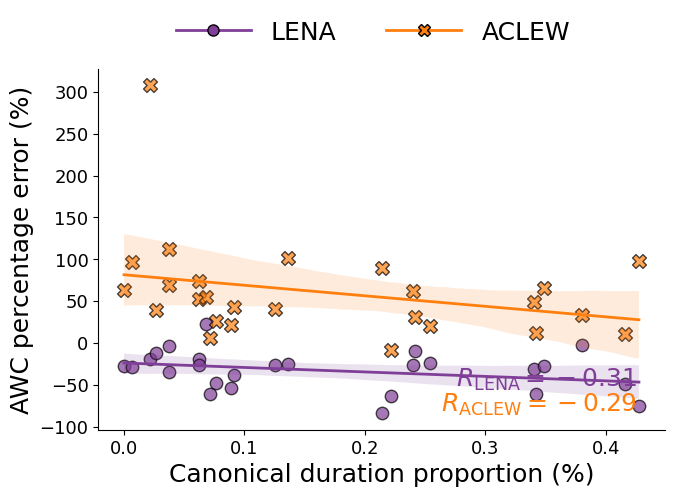

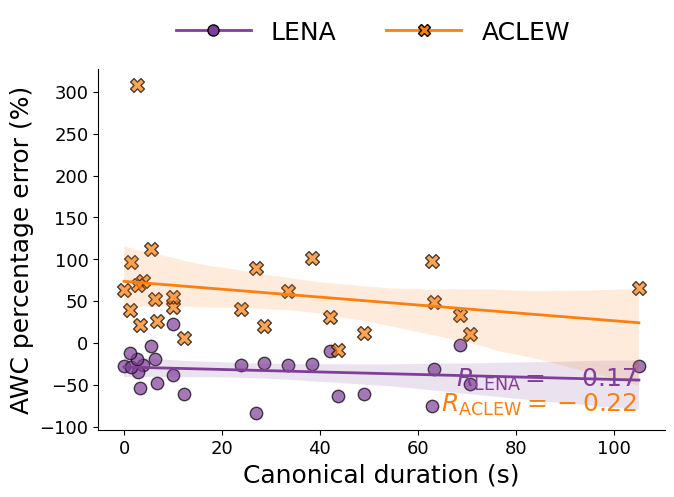

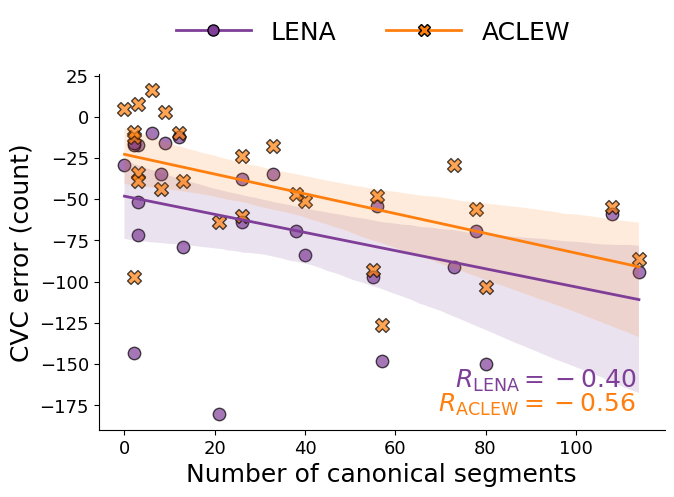

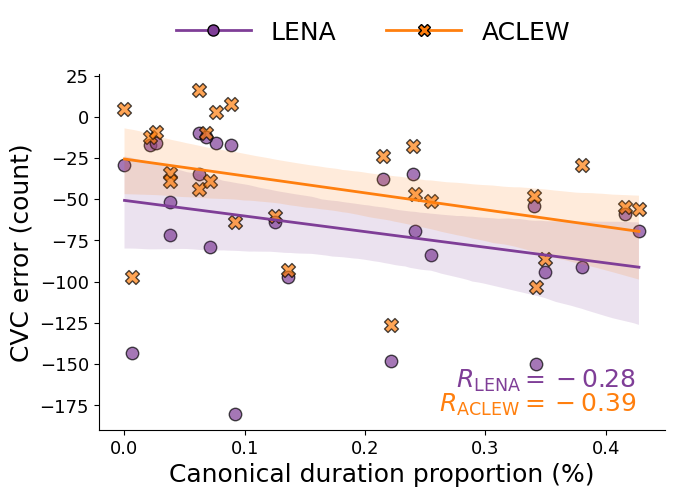

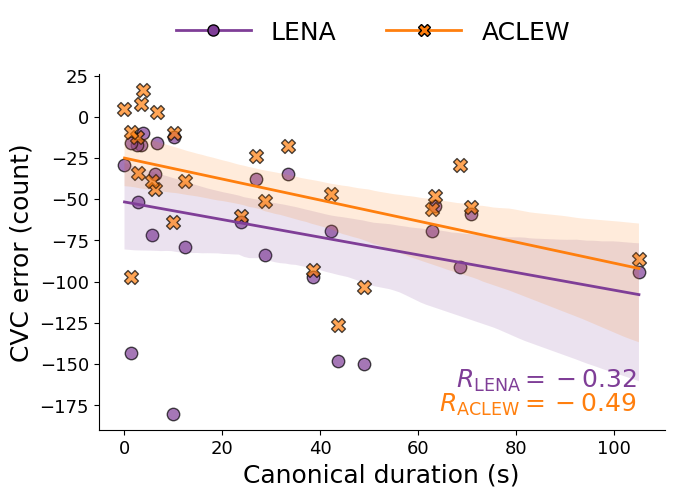

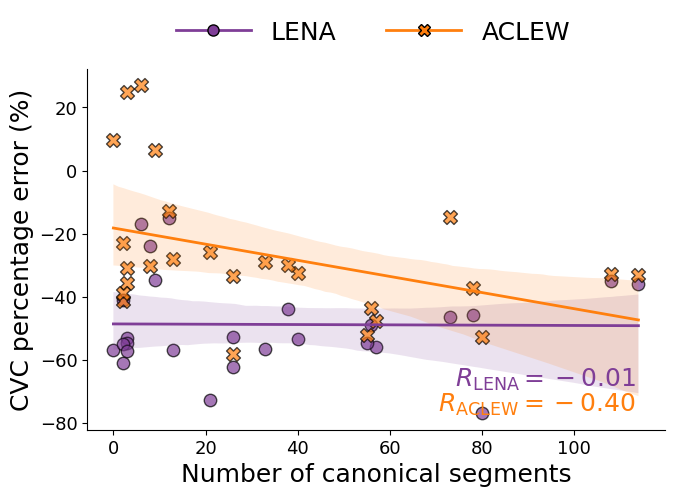

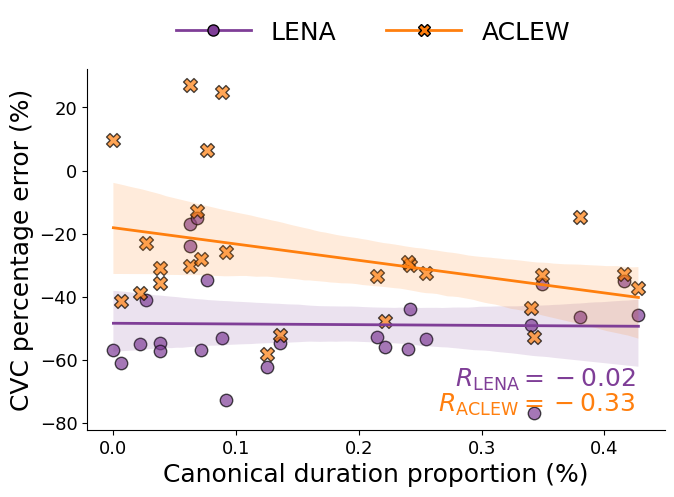

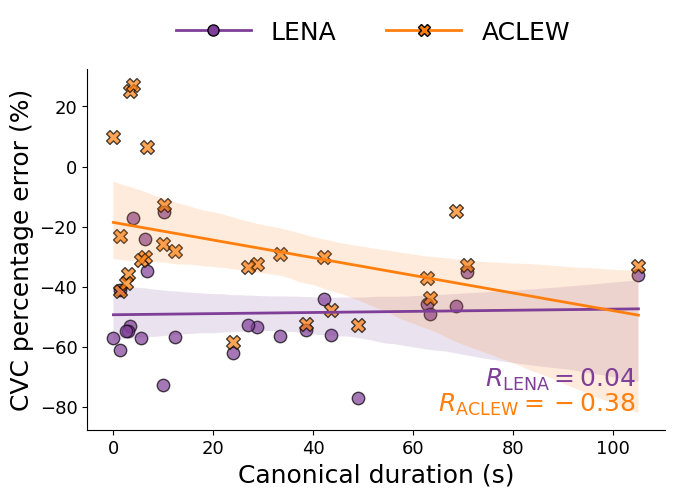

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy import stats
import matplotlib

matplotlib.rcParams.update({'font.size': 18, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})

def plot_volubility_scatter(lena_df, aclew_df, y_metric, x_measure, save_path=None):
    """
    Create scatter plot with regression lines for LENA and ACLEW data.
    
    Parameters:
    -----------
    lena_df : pandas DataFrame
        DataFrame containing LENA scores
    aclew_df : pandas DataFrame
        DataFrame containing ACLEW scores
    y_metric : str
        Column name for the y-axis (performance metric)
    x_measure : str
        Column name for the x-axis (child measure)
    save_path : str, optional
        Path to save the figure, if None the figure is not saved
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    x_name = {
        'can_voc_dur_CHI': 'Canonical duration (s)',
        'cp_dur': 'Canonical duration proportion (%)',
        'can_voc_CHI': 'Number of canonical segments'
    }

    y_name = {
        '5s_CTC': 'CTC',
        'wc_adu': 'AWC',
        'CVC': 'CVC'
    }
    metric_name = {
        'me': 'error (count)',
        'mpe': 'percentage error (%)'
        } 

    x_label = x_name[x_measure]
    y_label = y_name['_'.join(y_metric.split('_')[:-1])] + ' ' + metric_name[y_metric.split('_')[-1]]
    # Define colors
    lena_color = '#7F3E97'
    aclew_color = '#ff7f0e'
    cm = 1/2.54
    
    # Create figure
    fig, ax = plt.subplots(figsize=(18*cm, 12*cm))
    
    # Plot LENA data with regression line and confidence interval
    sns.regplot(x=x_measure, y=y_metric, data=lena_df, 
                scatter_kws={'color': lena_color, 'alpha': 0.7, 's': 80, 'edgecolor': 'black', 'marker': 'o'},
                line_kws={'color': lena_color, 'lw': 2},
                ax=ax, ci=95)
    
    # Plot ACLEW data with regression line and confidence interval
    sns.regplot(x=x_measure, y=y_metric, data=aclew_df, marker='X',
                scatter_kws={'color': aclew_color, 'alpha': 0.7, 's': 100, 'edgecolor': 'black'},
                line_kws={'color': aclew_color, 'lw': 2},
                ax=ax, ci=95)

    # Calculature correlation statistics for LENA
    lena_mask = ~np.isnan(lena_df[x_measure]) & ~np.isnan(lena_df[y_metric])
    lena_corr, lena_p = stats.pearsonr(lena_df.loc[lena_mask, x_measure], lena_df.loc[lena_mask, y_metric])
    lena_corr_text =  f'$R_{{\\mathrm{{LENA}}}} = {lena_corr:.2f}$'
  
    # Calculate correlation statistics for ACLEW
    aclew_mask = ~np.isnan(aclew_df[x_measure]) & ~np.isnan(aclew_df[y_metric])
    aclew_corr, aclew_p = stats.pearsonr(aclew_df.loc[aclew_mask, x_measure], aclew_df.loc[aclew_mask, y_metric])
    aclew_corr_text = f'$R_{{\\mathrm{{ACLEW}}}} = {aclew_corr:.2f}$'
   
    
    # Add correlation text
    ax.text(0.95, 0.12, lena_corr_text, 
            transform=ax.transAxes, color=lena_color,
            fontweight='bold', horizontalalignment='right')
    ax.text(0.95, 0.05, aclew_corr_text, 
            transform=ax.transAxes, color=aclew_color, 
            fontweight='bold', horizontalalignment='right')
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Create custom legend
    legend_elements = [
        Line2D([0], [0], color=lena_color, marker='o', label='LENA', lw=2, 
               markersize=8, markerfacecolor=lena_color, markeredgecolor='black'),
        Line2D([0], [0], color=aclew_color, marker='X', label='ACLEW', lw=2, 
               markersize=8, markerfacecolor=aclew_color, markeredgecolor='black')
    ]
    fig.legend(handles=legend_elements, ncol=3, bbox_to_anchor=(0.55, 1.02), 
               loc='center', frameon=False, handlelength=3)
    
    plt.tight_layout()

    return fig, ax

y_metrics = ['5s_CTC_me', '5s_CTC_mpe', 'wc_adu_me', 'wc_adu_mpe', 'CVC_me', 'CVC_mpe']
x_measures = ['can_voc_CHI', 'cp_dur', 'can_voc_dur_CHI']

for y_metric in y_metrics:
    for x_measure in x_measures:
        fig, ax = plot_volubility_scatter(lena_scores, aclew_scores, y_metric=y_metric, x_measure=x_measure)
        plt.savefig(f'/home/engaclew/neurogen/figures/volubility/{y_metric}_asf_{x_measure}.png', dpi=300, bbox_inches='tight')
        plt.show()

